# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from pandas.errors import SettingWithCopyWarning
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import (
    make_scorer,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from utils import mape, mean_std_cross_val_scores
from xgboost import XGBRegressor

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm

# 1. Data

In [2]:
df = pd.read_csv(
    "../data/processed/seoul_fine_dust_weather_2008_2021_for_ml.csv",
    index_col=0,
    parse_dates=True,
).reset_index()

In [3]:
df.head()

,date,temp(°C),precipitation(mm),wind_speed(m/s),wind_direction,humidity(%),local_P(hPa),cloud_cover,lowest_ceiling(100m),month,PM10_Counts,PM25_Counts,log_PM10_Counts,log_PM25_Counts
0,2008-01-01 10:00:00,-7.6,0.0,4.6,340.0,47.0,1010.7,2.0,12.0,1,30.0,11.0,3.433987,2.484907
1,2008-01-01 11:00:00,-6.9,0.0,4.1,290.0,42.0,1010.7,2.0,12.0,1,29.0,13.0,3.401197,2.639057
2,2008-01-01 12:00:00,-5.8,0.0,4.1,290.0,42.0,1010.7,2.0,12.0,1,29.0,12.0,3.401197,2.564949
3,2008-01-01 13:00:00,-5.0,0.0,4.1,290.0,36.0,1009.9,0.0,10.0,1,28.0,12.0,3.367296,2.564949
4,2008-01-01 14:00:00,-4.4,0.0,4.1,290.0,36.0,1009.9,0.0,10.0,1,27.0,13.0,3.332205,2.639057


In [4]:
df["month"] = df["month"].astype("category")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122733 entries, 0 to 122732
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  122733 non-null  datetime64[ns]
 1   temp(°C)              122733 non-null  float64       
 2   precipitation(mm)     122733 non-null  float64       
 3   wind_speed(m/s)       122733 non-null  float64       
 4   wind_direction        122733 non-null  float64       
 5   humidity(%)           122733 non-null  float64       
 6   local_P(hPa)          122733 non-null  float64       
 7   cloud_cover           122733 non-null  float64       
 8   lowest_ceiling(100m)  122733 non-null  float64       
 9   month                 122733 non-null  category      
 10  PM10_Counts           122733 non-null  float64       
 11  PM25_Counts           122733 non-null  float64       
 12  log_PM10_Counts       122733 non-null  float64       
 13 

# 2. Train/Test Split

The data is in the form of timeseries, however the approach taken here is more of supervised learning. I didn't intentionally shuffle the data just to keep them in the format of timeseries.

In [6]:
train_df = df.query("date < '2016-01-01 00:00:00'")
test_df = df.query("date >= '2016-01-01 00:00:00'")

train_df.set_index("date", inplace=True)
test_df.set_index("date", inplace=True)

In [7]:
X_train = train_df.drop(
    columns=["PM10_Counts", "PM25_Counts", "log_PM10_Counts", "log_PM25_Counts"]
)
y_train = train_df["log_PM10_Counts"]

X_test = test_df.drop(
    columns=["PM10_Counts", "PM25_Counts", "log_PM10_Counts", "log_PM25_Counts"]
)
y_test = test_df["log_PM10_Counts"]

Since `PM10_Counts` and `PM25_Counts` have similar trends, only `PM10_Counts` was used as target for simplicity.

# 3. Feature Selection

In [8]:
numerical_features = list(X_train.columns)
numerical_features.remove("month")
numerical_features

['temp(°C)',
 'precipitation(mm)',
 'wind_speed(m/s)',
 'wind_direction',
 'humidity(%)',
 'local_P(hPa)',
 'cloud_cover',
 'lowest_ceiling(100m)']

In [9]:
categorical_feature = ["month"]

In [10]:
ct = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_feature),
)

# 4. Machine Learning

In [11]:
results = {}

In [12]:
mape_scorer = make_scorer(mape, greater_is_better=False)

## 4.1. Baseline Model

In [13]:
pipe_dummy = make_pipeline(ct, DummyRegressor())

In [14]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True, scoring=mape_scorer
)

In [15]:
pd.DataFrame(results)

,Dummy
fit_time,0.027 (+/- 0.003)
score_time,0.007 (+/- 0.001)
test_score,-14.029 (+/- 1.575)
train_score,-13.870 (+/- 0.323)


## 4.2. Various ML Models

In [16]:
random_state = 123

pipe_ridge = make_pipeline(ct, Ridge(max_iter=2000, random_state=random_state))
pipe_rf = make_pipeline(ct, RandomForestRegressor(random_state=random_state))
pipe_xgb = make_pipeline(ct, XGBRegressor(random_state=random_state, verbosity=0))
pipe_lgbm = make_pipeline(ct, LGBMRegressor(random_state=random_state))
pipe_catb = make_pipeline(
    ct, CatBoostRegressor(random_state=random_state, verbose=0, loss_function="RMSE")
)

In [17]:
models = {
    "ridge": pipe_ridge,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [18]:
%%time

for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=mape_scorer
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:18<00:00, 39.70s/it]

CPU times: total: 8min 9s
Wall time: 3min 18s


In [19]:
pd.DataFrame(results)

,Dummy,ridge,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.027 (+/- 0.003),0.037 (+/- 0.003),30.761 (+/- 0.117),1.367 (+/- 0.070),0.264 (+/- 0.008),5.383 (+/- 0.122)
score_time,0.007 (+/- 0.001),0.008 (+/- 0.002),0.260 (+/- 0.013),0.022 (+/- 0.000),0.025 (+/- 0.002),0.084 (+/- 0.003)
test_score,-14.029 (+/- 1.575),-11.993 (+/- 1.064),-11.459 (+/- 0.947),-11.119 (+/- 0.733),-10.894 (+/- 0.792),-10.843 (+/- 0.770)
train_score,-13.870 (+/- 0.323),-11.769 (+/- 0.206),-2.785 (+/- 0.063),-7.992 (+/- 0.111),-9.293 (+/- 0.146),-8.390 (+/- 0.138)


`LightGBM` and `CatBoost` performed best among the models tested. Considering the computation speed, `LightGBM` was mainly used for analysis in the subsequent notebooks.

# 5. Evaluation

In [20]:
pipe_dummy.fit(X_train, y_train)
pipe_ridge.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)
pipe_lgbm.fit(X_train, y_train)
pipe_catb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['temp(°C)',
                                                   'precipitation(mm)',
                                                   'wind_speed(m/s)',
                                                   'wind_direction',
                                                   'humidity(%)',
                                                   'local_P(hPa)',
                                                   'cloud_cover',
                                                   'lowest_ceiling(100m)']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x00000227E292FC10>)])

In [21]:
models = {
    "dummy": pipe_dummy,
    "ridge": pipe_ridge,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [22]:
for name, model in models.items():
    test_df[f"{name}_prediction"] = np.expm1(model.predict(X_test))

## 5.1 Hourly Prediction

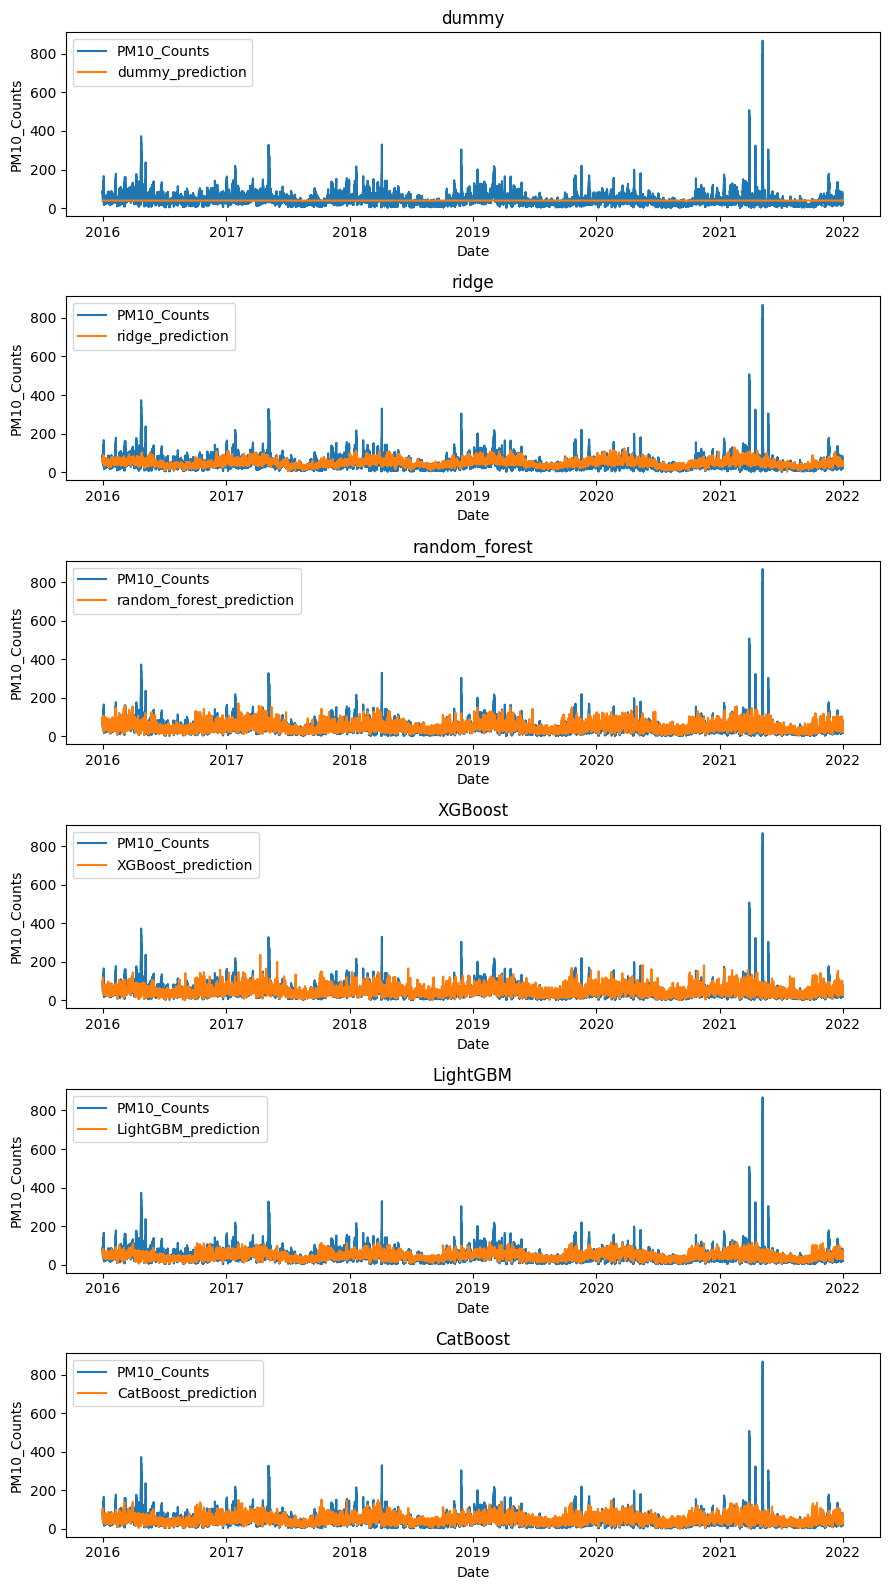

In [23]:
fig, axs = plt.subplots(figsize=(9, 16), nrows=6, ncols=1)

for i, name in enumerate(models.keys()):
    axs[i].plot(test_df.index, test_df["PM10_Counts"], label="PM10_Counts")
    axs[i].plot(test_df.index, test_df[f"{name}_prediction"], label=f"{name}_prediction")
    axs[i].set_title(f"{name}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("PM10_Counts")
    axs[i].legend()
fig.tight_layout()
plt.show()

In [24]:
# Due to the size of notebooks, the following codes for plotly were commented.
# import plotly.graph_objects as go

# for name, model in models.items():
#     fig = go.Figure()
#     fig.add_scatter(x=test_df.index, y=test_df["PM10_Counts"], name="PM10_Counts")
#     fig.add_scatter(
#         x=test_df.index, y=test_df[f"{name}_prediction"], name=f"{name}_prediction"
#     )
#     fig.update_layout(
#         autosize=False, width=1000, height=300, margin=dict(l=10, r=10, t=10, b=10)
#     )
#     fig.update_layout(legend=dict(yanchor="bottom", y=0.8, xanchor="left", x=0.01))
#     fig.show();

## 5.2. Monthly Prediction

In [25]:
test_df_1 = test_df.copy()

In [26]:
test_df_1.reset_index(inplace=True)

In [27]:
test_df_1["year_month"] = test_df_1["date"].dt.to_period("M")

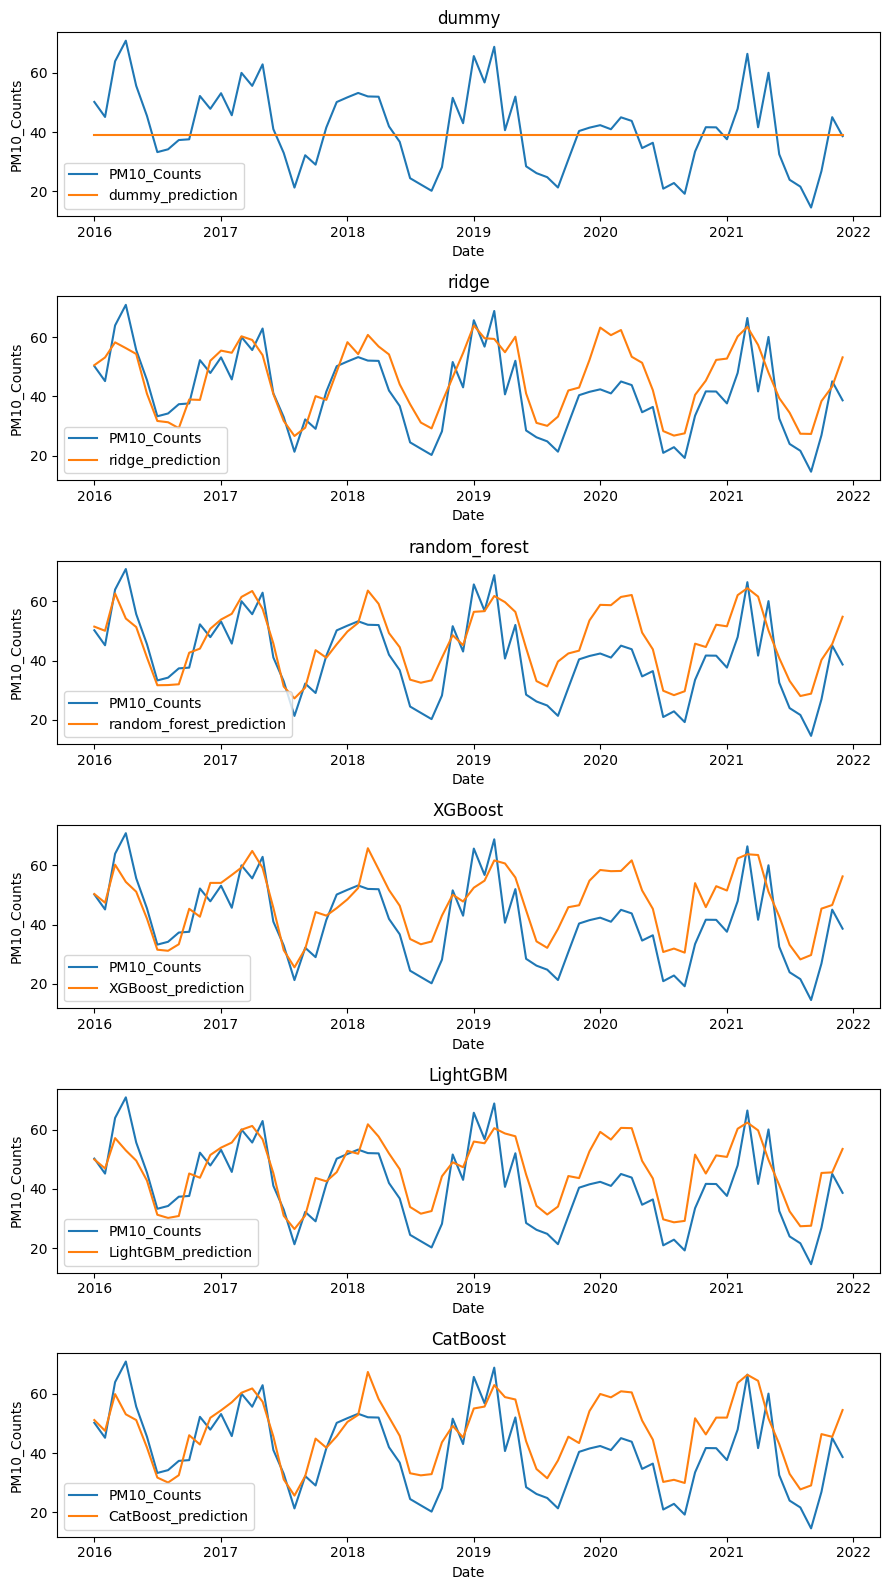

In [28]:
fig, axs = plt.subplots(figsize=(9, 16), nrows=6, ncols=1)

for i, name in enumerate(models.keys()):
    temp_df = test_df_1.groupby(["year_month"])[["PM10_Counts", f"{name}_prediction"]].mean()
    temp_df = temp_df.reset_index()
    temp_df["year_month"] = temp_df["year_month"].astype("datetime64[ns]")
    axs[i].plot(temp_df["year_month"], temp_df["PM10_Counts"], label="PM10_Counts")
    axs[i].plot(temp_df["year_month"], temp_df[f"{name}_prediction"], label=f"{name}_prediction")
    axs[i].set_title(f"{name}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("PM10_Counts")
    axs[i].legend()
fig.tight_layout()
plt.show()
fig.savefig("../img/predictions_by_MLs_monthly.png")